<h5>Fraudulent credit card detection</h5>

In [5]:
import csv
import pandas as pd
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize']=14,8
RANDOM_SEED=42
LABELS=['Normal','Fraud']

In [6]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [7]:
dp=pd.read_csv("C:\Windows\Lenovo\\creditcard.csv")

In [8]:
dp.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [10]:
dp.shape

(284807, 31)

exploratory data analysis

In [11]:
dp.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

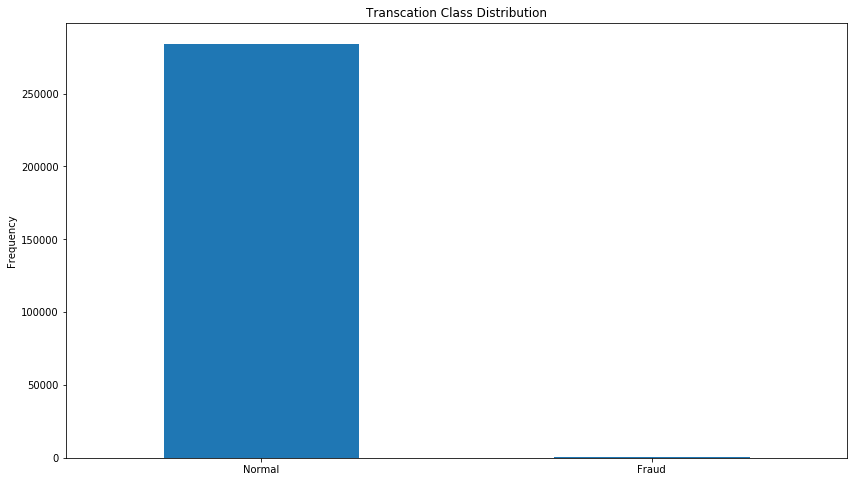

In [12]:
count_classes=pd.value_counts(dp['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.title('Transcation Class Distribution')
plt.xticks(range(2),LABELS)
plt.ylabel('Frequency')


In [13]:
fraud=dp[dp['Class']==1]
normal=dp[dp['Class']==0]

In [14]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [15]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

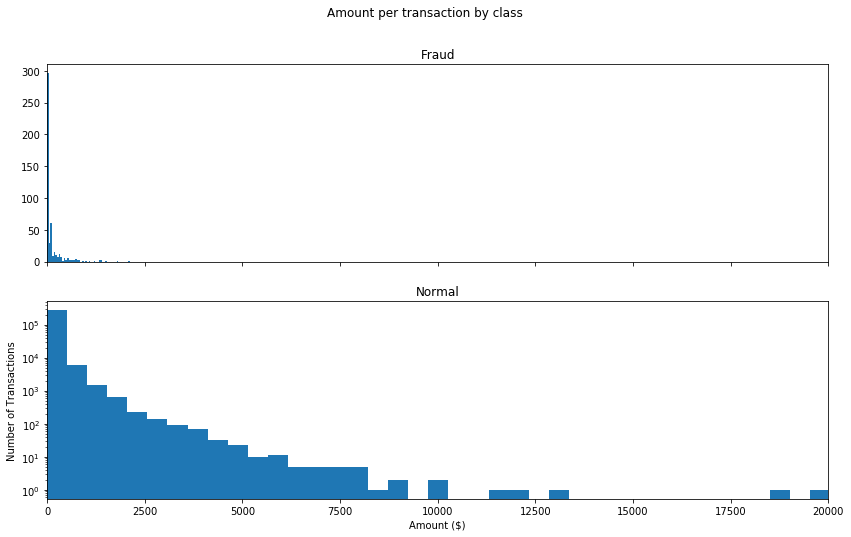

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

 We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.


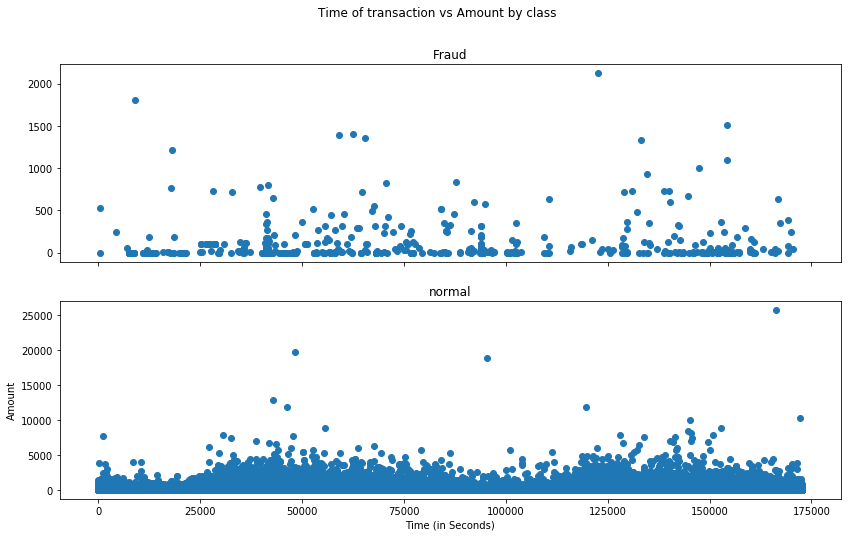

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

if u wish to save time on pre-processing then u can also take .sample which will be a percentage of data given since the given dataset is large

In [18]:
#Take some sample of the data

dp_1= dp.sample(frac = 0.2,random_state=1)

dp_1.shape

(56961, 31)

In [19]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = dp_1[dp_1['Class']==1]

Valid = dp_1[dp_1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [20]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0015296972254457222
Fraud Cases : 87
Valid Cases : 56874


In [21]:
#Create independent and Dependent Features
columns = dp_1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = dp_1[columns]
Y = dp_1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(56961, 30)
(56961,)


<b>Isolation Forest Algorithm :</b><br>
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

<b>Local Outlier Factor(LOF) Algorithm</b><br>
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [22]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
   
}


In [23]:
type(classifiers)

dict

here we r using three diffrent models isolation forest,local outlier,SVM..to see which model works best with imbalanced datasets

In [24]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))


C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 137
Accuracy Score :
0.9975948455961097
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.22      0.22      0.22        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.61      0.61      0.61     56961
weighted avg       1.00      1.00      1.00     56961

Local Outlier Factor: 173
Accuracy Score :
0.9969628342199048
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

   micro avg       1.00      1.00      1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\svm\classes.py:1177: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


Support Vector Machine: 29070
Accuracy Score :
0.48965081371464686
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.49      0.66     56874
           1       0.00      0.56      0.00        87

   micro avg       0.49      0.49      0.49     56961
   macro avg       0.50      0.53      0.33     56961
weighted avg       1.00      0.49      0.66     56961



In [ ]:
#from IPython.display import YouTubeVideo
#YouTubeVideo('https://youtu.be/frM_7UMD_-A')

<h6>Observations :</h6>
so in the pool of 20% of sample of the dataset 
Isolation Forest detected 137 errors versus Local Outlier Factor detecting 173 errors vs. SVM detecting 29070 errors<br>
Isolation Forest has a 99.75% more accurate than LOF of 99.69% and SVM of 48.96<br>
When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see<br> that the detection of fraud cases is around 22 % versus LOF detection rate of just 1 % and SVM of 0%.<br>
So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.<br>
We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of<br> computational expense.<br>We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

In [27]:
hide_toggle(for_next=True)

In [28]:
#from IPython.display import YouTubeVideo
#YouTubeVideo('https://youtu.be/frM_7UMD_-A')